In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

* Import libraries and data

In [203]:
%config IPCompleter.greedy=True
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import seaborn as sns
sns.set_style('whitegrid')
import missingno as msno
from time import time
from math import sqrt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as st
from scipy.special import boxcox1p
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import RobustScaler, LabelEncoder, StandardScaler, PowerTransformer
from sklearn.linear_model import Lasso, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from xgboost.sklearn import XGBRegressor
%matplotlib inline

train_clean = pd.read_csv('hw4-trainingset-wsa2113.csv')
train = train_clean.copy()
test_clean = pd.read_csv('hw4-testset-wsa2113.csv')
test = test_clean.copy()

print('train shape:',train.shape)
print('test shape:',test.shape)

train shape: (20000, 380)
test shape: (24500, 380)


* Split data

In [204]:
X_train = train.drop(['uni','row'], axis = 1)
y_train = train['job_performance']
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0)

ntrain = X_train.shape[0]
nval = X_val.shape[0]

X_test = test[X_train.columns]

# combine train and val for eda and feature engineering
train_full = pd.concat([X_train, X_val], sort=True).reset_index(drop=True)
train_full['dataset'] = np.repeat(['Train','Test'], [ntrain, nval], axis=0)

## EDA  
* Explore target variable

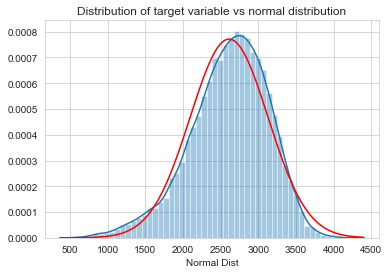

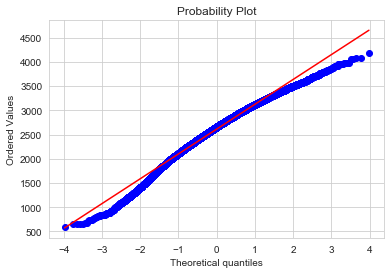

In [186]:
sns.distplot(train_full.job_performance, axlabel='Normal Dist', 
             fit=st.norm, fit_kws={'color':'red'})
plt.title('Distribution of target variable vs normal distribution')
plt.show()
st.probplot(train_full.job_performance, plot=plt)
plt.show()

* Data is close to normally distributed, but it has a left skew. I will apply a Box-Cox transform so it will approach a normal distribution.

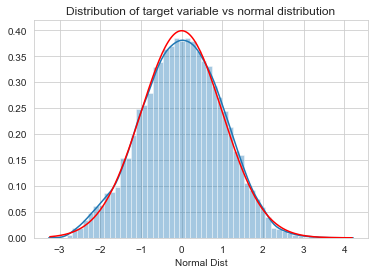

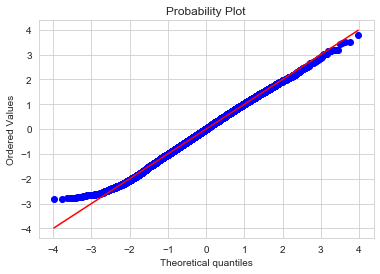

In [187]:
# apply power transformer
pt = PowerTransformer(method='box-cox')
pt.fit(train_full.job_performance[:,np.newaxis])
train_full.job_performance = pt.transform(train_full.job_performance[:,np.newaxis]).squeeze()

# plot results
sns.distplot(train_full.job_performance, axlabel='Normal Dist', 
             fit=st.norm, fit_kws={'color':'red'})
plt.title('Distribution of target variable vs normal distribution')
plt.show()
st.probplot(train_full.job_performance, plot=plt)
plt.show()

### Impute Nulls

In [199]:
# go through null columns manually

null_cols = train_full.isnull().sum().sort_values(ascending=False).index.values
null_counts = train_full.isnull().sum().sort_values(ascending=False)
pd.DataFrame(null_counts[null_counts > 0]).to_csv('null_cols.csv')

In [208]:
# should be categorical, maybe binned
# v163, v241, v154, v133, v187, v104, yrsget, v33

# cols with lots of categories
# cnt_brth, v202, v231

# convert 99999 in reg_tl2 to na

# these two are mixed letters and numbers, should be categorical
# convert 9995,9996,9996.0,9999 in isic2l to nan before converting all columns
# convert 9995,9996,9999 to nan in isic2c before converting

# convert 9995, 9996 in v239 to nan
# convert 9996, 9996.0, 9999, 9999.0 in v71 to nan
# convert 999 in lng_home to nan
# convert 9996.0, 9999.0 in v224 to nan
# convert 9995, 9996, 9997, 9997.0, 9998, 9999 in isco1c to nan
# convert in v105 to nan

nan_vals = [999, 9995, 9995.0, 9996, 9996.0, 9997, 9997.0, 9998, 9998.0,
            9999, 9999.0, 99999, '999', '9995', '9995.0', '9996', '9996.0', '9997', '9997.0', '9998', '9998.0',
            '9999', '9999.0', '99999']

cols_to_drop = ['v262','v105','edcat6']

impute_as_mean = ['leavedu','planning','influence','readwork','v202','v231','v272','age_r',
                  'icthome','writhome','yrsqual_t','yrsqual','v60','readhome','readytolearn',
                  'v71','v239','v224']

impute_as_mode = ['v69','nativelang','v85','v50','v225','v101','nfe12njr','v17','v227',
                  'v285','v102','isic2l','v151','paidwork5','v26','v253','v284','v200',
                  'v258','v270','edlevel3','isic2c','v27','ctryrgn','readhome_wle_ca',
                  'writhome_wle_ca','readytolearn_wle_ca','v177','v114','v57','v267','v149',
                  'v260','edcat7','edwork','v218','v171','v14','v111','v186','v132',
                  'v162','computerexperience','v7','v240','v201','fe12','v90','paidwork12',
                  'nopaidworkever','v84','v205','v122','isco1c']


impute_as_zero = ['v44','v144','v199','v172','v109','v100','v10','v287','v129','v215',
                  'v163','v268','v252','v37','v169','earnmthselfppp','imyrs','v45',
                  'v78','v22','v241','v194','v283','v154','v113',
                  'v130','v196','v61','v160','v110','v156','v81','v145','v41','v136',
                  'v210','v187','v207','v133','nfehrsjr','nfehrsnjr','v87','earnhrbonusppp',
                  'earnhrbonus','earnmthbonusppp','earnmthbonus','earnhrppp','earnhr',
                  'earnmthppp','earnmth','v184','nfehrs','v104','earnmthall','earnmthallppp',
                  'v63','ictwork','yrsget','v33','learnatwork','writwork','v135','v1',
                  'taskdisc','v52','v235','v242','v97','v94','v206']

impute_as_na = ['v159','v266','v38','v89','v117','v126','v168','v274','v257','v230','v245','v93','v56',
                'v107','v243','v112','v119','v192','v265','v121','v30','v58','v9','v72',
                'v4','v29','v211','leaver1624','v222','v203','v281','v35','v95',
                'v286','v273','v259','v174','v5','v217','v183','v67','v238','v291','v137',
                'v234','v185','v269','v91','v209','v179','v36','vet','v47','v236','v3',
                'v176','v271','v250','v23','v195','ictwork_wle_ca','v146','v106','v73',
                'v40','v277','v289','v96','v62','earnhrbonusdcl','v228','earnhrdcl','v255',
                'v212','cnt_h','v8','earnflag','v221','v48','v115','v19','v251','yearlyincpr',
                'monthlyincpr','v214','learnatwork_wle_ca','v261','ctryqual','v70','v82',
                'v46','v53','cnt_brth','v142','v140','v276','v246','v244','v158','v188',
                'v181','v263','v198','taskdisc_wle_ca','v77','v99','v247','v229','v248',
                'v216','v18','v134','v2','v51','v124','v282','v13','v42','v34','v166',
                'v164','v204','v197','v193','v123','v275','v131','v141','v292','v139',
                'v108','v189','v190','v25','influence_wle_ca','writwork_wle_ca','v173',
                'readwork_wle_ca','v165','planning_wle_ca','v155','v180','v24','v233',
                'v278','v103','v178','v152','v31','birthrgn','icthome_wle_ca','v208',
                'v288','v175','v43','v15','v280','v237','iscoskil4','v256','v153',
                'edcat8','reg_tl2','v28','fnfaet12jr','fnfaet12njr','faet12njr','faet12jr',
                'faet12','fnfaet12','imyrcat','fnfe12jr','nfe12jr','v59','nfe12','v92',
                'nativespeaker','v88','v74','v157','v65','v191','neet','lng_ci','v170',
                'v76','v127','v147','v150','v6','v83','v220',
                'v39','v118','v254','v290','v16','v12','v55','v68','v64','v32','v125',
                'v79','v232','v98', 'v226', 'v161', 'v264', 'v213', 'v20', 'v11', 'v138', 
                'imyrs_c', 'v182','v75','v223','earnmthalldcl','lng_home','aetpop']

nan_cols = []
nan_cols.extend(impute_as_mean)
nan_cols.extend(impute_as_mode)
nan_cols.extend(impute_as_zero)
nan_cols.extend(impute_as_na)

In [210]:
train_full = train_full.replace(nan_vals, np.nan).copy()

In [ ]:
# drop columns
train_full.drop(cols_to_drop, inplace=true, axis=1)


In [168]:
nan_cols = []
nan_cols.extend(impute_as_mean)
nan_cols.extend(impute_as_mode)
nan_cols.extend(impute_as_zero)
nan_cols.extend(impute_as_na)
len(nan_cols)

362

In [169]:
seen = []
for col in null_counts[null_counts > 0].index.values:
    if col not in nan_cols:
        print(col)

v262
v105
edcat6


In [144]:
len(impute_as_mean)+len(impute_as_mode)+len(impute_as_na)+len(impute_as_zero)

356

In [211]:
col = 'isco1c'
train_full[col].value_counts()

5       1980
2       1963
3       1597
7       1194
4       1025
9        827
1        794
8        747
5        514
2        512
3        379
7        296
4        249
6        219
8        201
9        200
1        195
6         60
0         48
0         18
   .       2
Name: isco1c, dtype: int64

In [107]:
"""v98,v226,v161,v264,v213,v20,v11,v138,imyrs_c,v182""".split(',')

['v98',
 'v226',
 'v161',
 'v264',
 'v213',
 'v20',
 'v11',
 'v138',
 'imyrs_c',
 'v182']

In [56]:
cols_to_do = []
for col in null_cols:
    if col not in all_nan:
        cols_to_do.append(col)
        
# null_cols = train_full.isnull().sum().sort_values(ascending=False).index.values
# null_counts = train_full.isnull().sum().sort_values(ascending=False)
# pd.DataFrame(null_counts[null_counts > 0])#.to_csv('null_cols.csv').shape

# pd.DataFrame(cols_to_do)#.to_csv('cols.csv')
null_counts = train_full[cols_to_do].isnull().sum().sort_values(ascending=False)
pd.DataFrame(null_counts[null_counts > 0]).to_csv('null_cols.csv')

In [8]:
def strange_nans(nan_types, *args):
    for nan_t in nan_types:
        for arg in args:
            for col in arg:
                imp = SimpleImputer()

# strange_nans(nan_vals, impute_as_mean, impute_as_mode, impute_as_zero, impute_as_zero)
imp = SimpleImputer(missing_values=nan_vals, strategy='constant', fill_value=np.nan)
imp.fit_transform(train_full)


full_train['PoolQC'].replace(np.nan, 'None', regex=True, inplace=True)

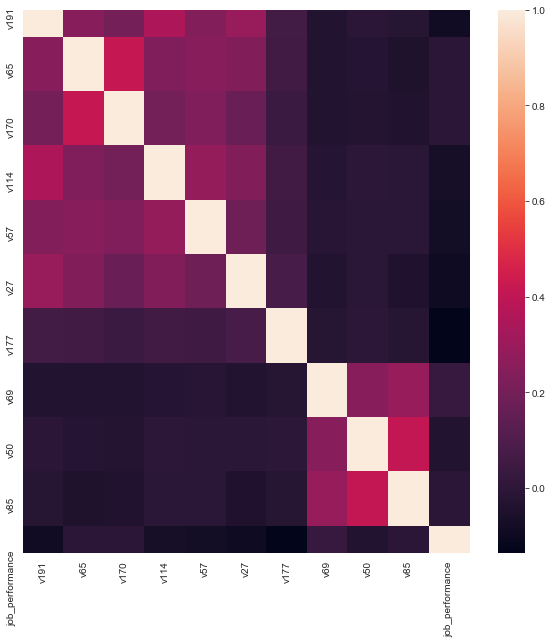

In [80]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline

s = """v191,v65,v170,v114,v57,v27,v177,v69,v50,v85""".split(',')
s.append('job_performance')

pipe = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('enc', OrdinalEncoder())
])

d = pd.DataFrame(data=pipe.fit_transform(train_full[s]), columns=s)
corr = d.corr()

plt.figure(figsize=(10,10))
sns.heatmap(corr)


In [84]:
d.iloc[:,:-1].sum(axis=1).corr(d.job_performance)

-0.106889359963189

# Baseline
* Remove columns
    * Drop high % null cols and rows
        * Threshold = 75%
    * Drop columns unrelated to performance
    * Drop target


* Split data into train, val, and test sets

In [ ]:
from sklearn.model_selection import train_test_split

X_train = train.drop(['uni','row','job_performance'], axis = 1)
y_train = train['job_performance']

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0)
X_test = test[X_train.columns]
y_test = test['job_performance']

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(15000, 377)
(15000,)
(5000, 377)
(5000,)
(24500, 377)
(24500,)


* Identify categorical and numerical columns
* Fix columns with multiple data types

In [ ]:
categorical_obj_cols = X_train.dtypes == object
cat_cols = categorical_obj_cols[categorical_obj_cols==True].index.values
num_cols = categorical_obj_cols[categorical_obj_cols==False].index.values

for col in cat_cols:
    X_train[col] = X_train[col].astype('str')
    X_val[col] = X_val[col].astype('str')
    
for col in num_cols:
    X_train[col] = X_train[col].astype('float')
    X_val[col] = X_val[col].astype('float')

### Build pipeline
    * impute nulls
    * scale numerical columns
    * OHE categorical columns

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from scipy.sparse import coo_matrix

num_transform = Pipeline(
    [
        ('num_imputer', IterativeImputer(n_nearest_features=5, random_state=0, add_indicator=True,
                                         max_iter=100)),
        ('num_scaler', StandardScaler()),
        ('poly', PolynomialFeatures())
    ]
)

cat_transform = Pipeline(
    [
        ('nan_imputer', SimpleImputer(strategy='constant', fill_value='missing', add_indicator=True)),
        ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ('cat_scaler', StandardScaler(with_mean=False))
    ]
)

preprocessor = ColumnTransformer(
    [
        ('num', num_transform, ~categorical_obj_cols),
        ('cat', cat_transform, categorical_obj_cols),
    ]
)
    
X_train_pr = preprocessor.fit_transform(X_train)

    
X_train_pr = coo_matrix(preprocessor.fit_transform(X_train).astype('float64'))
X_val_pr = coo_matrix(preprocessor.fit_transform(X_val).astype('float64'))

# X_train_pr = preprocessor.fit_transform(X_train).astype('float64')
# X_val_pr = preprocessor.fit_transform(X_val).astype('float64')



/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

In [ ]:
# for sparse representation

X_train_values = X_train_pr.data
X_train_indices = np.vstack((X_train_pr.row, X_train_pr.col))
i = torch.LongTensor(X_train_indices)
v = torch.FloatTensor(X_train_values)
X_train_shape = X_train_pr.shape

X_train_data = torch.sparse.FloatTensor(i, v, torch.Size(X_train_shape)).to_dense()
y_train = torch.FloatTensor(y_train)

In [ ]:
# for dense representation 

X_train = torch.FloatTensor(X_train_pr)
y_train = torch.FloatTensor(y_train)

X_val = torch.FloatTensor(X_val_pr)
y_val = torch.FloatTensor(y_val.values)

In [ ]:
n_cols, n_feat = X_train_data.shape
# n_cols, n_feat = X_train_pr.shape
print(n_cols, n_feat)

15000 15968


# FF NN

In [ ]:
# loss 267298.8750
class Model(nn.Module):
  def __init__(self, n_feat):
    super().__init__()
    self.lin_1 = nn.Linear(n_feat, 128)
    self.lin_2 = nn.Linear(128, 64)
    self.lin_3 = nn.Linear(64, 1)
    # self.lin_4 = nn.Linear(64, 1)

  def forward(self, x):
    x = F.sigmoid(self.lin_1(x))
    x = F.sigmoid(self.lin_2(x))
    # x = F.relu(self.lin_3(x))
    y_preds = self.lin_3(x)

    return y_preds

  # def forward(self, x):
  #   x = self.lin_1(x)
  #   x = self.lin_2(x)
  #   # x = F.relu(self.lin_3(x))
  #   y_preds = self.lin_3(x)

  #   return y_preds

# class Model(nn.Module):
#   def __init__(self, n_feat):
#     super().__init__()
#     self.lin_1 = nn.Linear(n_feat, 64)
#     self.lin_2 = nn.Linear(64, 32)
#     self.lin_3 = nn.Linear(32, 16)
#     self.lin_4 = nn.Linear(16, 1)

#   def forward(self, x):
#     x = F.relu(self.lin_1(x))
#     x = F.relu(self.lin_2(x))
#     x = F.relu(self.lin_3(x))
#     y_preds = self.lin_4(x)

#     return y_preds

In [ ]:
model = Model(n_feat)
loss_func = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [ ]:
# optimizer.zero_grad()
for epoch in range(200):
  # y_preds = model(X_train_data)
  y_preds = model(X_train)
  loss = loss_func(y_preds, y_train)
  print(loss)

  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([15000])) that is different to the input size (torch.Size([15000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(267298.6562, grad_fn=<MseLossBackward>)
tensor(267298.6562, grad_fn=<MseLossBackward>)
tensor(267298.6562, grad_fn=<MseLossBackward>)
tensor(267298.6562, grad_fn=<MseLossBackward>)
tensor(267298.6562, grad_fn=<MseLossBackward>)


KeyboardInterrupt: ignored

In [ ]:
# 

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(X_train_data, y_train)

bs = 10
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

In [ ]:
class Model(nn.Module):
  def __init__(self, n_feat):
    super().__init__()
    self.lin_1 = nn.Linear(n_feat, 512)
    # self.lin_2 = nn.Linear(128, 128)
    # self.lin_3 = nn.Linear(128, 128)
    # self.lin_4 = nn.Linear(128, 128)
    # self.lin_5 = nn.Linear(128, 128)
    self.lin_6 = nn.Linear(512, 1)

  def forward(self, x):
    x = F.sigmoid(self.lin_1(x))
    # x = F.sigmoid(self.lin_2(x))
    # x = F.sigmoid(self.lin_3(x))
    # x = F.sigmoid(self.lin_4(x))
    # x = F.sigmoid(self.lin_5(x))
    y_preds = self.lin_6(x)

    return y_preds

In [ ]:
model = Model(n_feat)
opt = torch.optim.SGD(model.parameters(), lr=0.001)
loss_func = nn.MSELoss()

In [ ]:
def fit(num_epochs, model, loss_fn, opt):
    for epoch in range(num_epochs):

      for X, y in train_dl:
          model.zero_grad()
          pred = model(X)
          loss = loss_fn(pred, y)

          # Perform gradient descent
          loss.backward()
          opt.step()
          
      print('Epoch: ', epoch)
      print('Training loss: ', loss_fn(model(X_train_data), y_train))
    

In [ ]:
fit(200, model, loss_func, opt)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:  0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([15000])) that is different to the input size (torch.Size([15000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training loss:  tensor(283086.6250, grad_fn=<MseLossBackward>)
Epoch:  1
Training loss:  tensor(272462.3750, grad_fn=<MseLossBackward>)
Epoch:  2
Training loss:  tensor(267797.5938, grad_fn=<MseLossBackward>)
Epoch:  3
Training loss:  tensor(277660.8750, grad_fn=<MseLossBackward>)
Epoch:  4
Training loss:  tensor(328249.9375, grad_fn=<MseLossBackward>)
Epoch:  5
Training loss:  tensor(268030.7500, grad_fn=<MseLossBackward>)
Epoch:  6
Training loss:  tensor(286913.5625, grad_fn=<MseLossBackward>)


In [ ]:
class Conv_net(nn.Module):
  def __init__(self, n_feat):
    super().__init__()




class Model(nn.Module):
  def __init__(self, n_feat):
    super().__init__()
    self.lin_1 = nn.Linear(n_feat, 128)
    self.lin_2 = nn.Linear(128, 128)
    self.lin_3 = nn.Linear(128, 128)
    self.lin_4 = nn.Linear(128, 128)
    self.lin_5 = nn.Linear(128, 128)
    self.lin_6 = nn.Linear(128, 1)

  def forward(self, x):
    x = F.sigmoid(self.lin_1(x))
    x = F.sigmoid(self.lin_2(x))
    x = F.sigmoid(self.lin_3(x))
    x = F.sigmoid(self.lin_4(x))
    x = F.sigmoid(self.lin_5(x))
    y_preds = self.lin_6(x)

    return y_preds